In [1]:
import os, sys
import time
from collections import OrderedDict

import numpy as np
from matplotlib import pyplot as plt

from fmpy import read_model_description, extract

from fmugym import FMUGym, FMUGymConfig, VarSpace, State2Out, TargetValue

import gymnasium as gym

### 1 Implement abstract FMUGym class

In [2]:
class FMUEnv(FMUGym):
    def __init__(self, config):
        self.init_states = {}
        super().__init__(config)

    # Used by step() and reset(), returns any relevant debugging information.
    def _get_info(self):
        return {'info_time':time.time()}

    # Retrieves FMU output values by possibly calling self.fmu_get_fmu_output for handling different FMU versions
    # and stores them in the self.observation dictionary. 
    # It can also add output noise (using self._get_output_noise()) and update the set point 
    def _get_obs(self):
        
        self._get_fmu_output()

        obs = np.array(list(self.observation.values())).flatten()
        
        noisy_observation = obs + self._get_output_noise()

        obs_dict = OrderedDict([
            ('observation', np.array(noisy_observation))
        ])
        return obs_dict

    # Returns input noise for each input component, potentially by sampling from the self.input_noise dictionary.
    def _get_input_noise(self):
        input_noise = []
        for inp_name in self.input_dict:
            noise_mean = self.input_noise[inp_name].low[0]
            noise_std = self.input_noise[inp_name].high[0]
            noise = np.random.normal(noise_mean, noise_std, 1)[0] # if normally distributed noise, implement custom sampling here
            input_noise.append(noise)  
        return np.array(input_noise)

    # Similar to self._get_input_noise, generates output noise for each output component,
    # potentially by sampling from the self.output_noise dictionary.
    def _get_output_noise(self):
        output_noise = []
        for out_name in self.output_dict:
            output_noise.append(self.output_noise[out_name].sample()[0])  # if normally distributed noise, implement custom sampling here
        return np.array(output_noise)

    # Returns two booleans indicating first the termination and second truncation status. 
    def _get_terminated(self):
        if self.time > self.stop_time:
                self.reset()
                return True, False
    
        for termination in self.terminations:
            min_value = self.terminations[termination].low[0]
            max_value = self.terminations[termination].high[0]
            if self.observation[termination] < min_value or self.observation[termination] > max_value:
                self.reset()
                return False, True
                    
        return False, False

    # Constructs the action space from a VarSpace object representing the inputs. 
    # It can use gymnasium.spaces.Box for continuous action spaces.
    def _create_action_space(self, inputs):
        lows = []
        highs = []
        for inp in inputs:
            lows.append(inputs[inp].low[0])
            highs.append(inputs[inp].high[0])
        action_space = gym.spaces.Box(low=np.array(lows), high=np.array(highs), dtype=np.float32)
        return action_space

    # Constructs the observation space returning it as a gymnasium.spaces.Dict. 
    # The observation space typically includes observation, achieved_goal, and desired_goal, each created from a VarSpace object.
    def _create_observation_space(self, outputs):
        lows = []
        highs = []
        for out in outputs:
            lows.append(outputs[out].low[0])
            highs.append(outputs[out].high[0])
        observation_space = gym.spaces.Dict({
            'observation': gym.spaces.Box(low=np.array(lows), high=np.array(highs), dtype=np.float32)
        })
        return observation_space

    # Random variations to initial system states and dynamic parameters by sampling from self.random_vars_refs 
    # and propagates to corresponding initial output values.  
    # It also allows for direct manipulation and randomization of set point goals using the self.y_stop class variable.
    def _noisy_init(self):
        
        # add noise to initial system state
        for var in self.random_vars_refs:
            var_ref = self.random_vars_refs[var][0]
            uniform_value = self.random_vars_refs[var][1].sample()[0]   # if normally distributed noise, implement custom sampling here
            self.init_states[var_ref] = uniform_value
        
        return self.init_states

    # Called by self.step() to add noise to action from RL library.
    # May be used to execute low-level controller and adapt action space.
    def _process_action(self, action):
        processed_action = action + self._get_input_noise()
        return processed_action
    
    # collect current values of randomized parameters with parameter_refs and store them in self.random_vars_refs
    def get_random_vars(self):
        params = {key: self.init_states[value[0]] for key, value in self.random_vars_refs.items()}
        return params
    
    # dummy methods to compy with the FMUGym interface
    def _process_reward(self, obs, acts, info):
        reward = self.compute_reward()
        return reward
    
    def compute_reward(self):
        return np.array([0.0])
    
    def setpoint_trajectory():
        return np.array([0.0])

### 2 Create FMUGymConfig object

In [34]:
# providing inputs, outputs and their noises with range of values
inputs = VarSpace("inputs")
inputs.add_var_box("R1", -2.0, 2.0)
inputs.add_var_box("S2", -2.0, 2.0)
inputs.add_var_box("C4", -2.0, 2.0)
inputs.add_var_box("S4", -2.0, 2.0)
inputs.add_var_box("C5", -2.0, 2.0)
inputs.add_var_box("R4", -2.0, 2.0)
inputs.add_var_box("N2", -2.0, 2.0)

# Input noise is normally distributed with gym.Box with lower bound as mean, higher as standard deviation
input_noise = VarSpace("input_noise")
input_noise.add_var_box("R1", 0.0, 0.05/3.0)
input_noise.add_var_box("S2", 0.0, 0.05/3.0)
input_noise.add_var_box("C4", 0.0, 0.05/3.0)
input_noise.add_var_box("S4", 0.0, 0.1/3.0)
input_noise.add_var_box("C5", 0.0, 0.05/3.0)
input_noise.add_var_box("R4", 0.0, 0.05/3.0)
input_noise.add_var_box("N2", 0.0, 0.05/3.0)

outputs = VarSpace("outputs")
outputs.add_var_box("FR1_min", -1e6, 1e6)
outputs.add_var_box("FR1_max", -1e6, 1e6)
outputs.add_var_box("FR2_min", -1e6, 1e6)
outputs.add_var_box("FR2_max", -1e6, 1e6)

output_noise = VarSpace("output_noise")
output_noise.add_var_box("FR1_min", 0.0, 0.0)
output_noise.add_var_box("FR1_max", 0.0, 0.0)
output_noise.add_var_box("FR2_min", 0.0, 0.0)
output_noise.add_var_box("FR2_max", 0.0, 0.0)

# randomized system parameters and their range of values
random_vars = VarSpace("random_vars")
# randomized initial initial states and their range of values -> not used, we have a static system
# random_vars.add_var_box("firstOrder.y_start", -0.5, 0.5)
# random_vars.add_var_box("firstOrder1.y_start", -0.5, 0.5)

# allowed range of output values, if exceeded termination (or rather truncation) of the episode
terminations = VarSpace("terminations") # for single step simulation, no termination is needed

# create FMUGymConfig object from all the above defined parameters
config = FMUGymConfig(fmu_path=os.path.abspath('FMUs/geom_tol.fmu'),
                      start_time=0.0,
                      stop_time=1.0,                # only simulate one step
                      sim_step_size=1.0,            # only simulate one step
                      action_step_size=1.0,         # only simulate one step
                      inputs=inputs,
                      input_noise=input_noise,
                      outputs=outputs,
                      output_noise=output_noise,
                      random_vars=random_vars,
                      terminations=terminations
                     )         

# 2nd config with no noise

# Input noise is normally distributed with gym.Box with lower bound as mean, higher as standard deviation
no_input_noise = VarSpace("input_noise")
no_input_noise.add_var_box("R1", 0.0, 0.0)
no_input_noise.add_var_box("S2", 0.0, 0.0)
no_input_noise.add_var_box("C4", 0.0, 0.0)
no_input_noise.add_var_box("S4", 0.0, 0.0)
no_input_noise.add_var_box("C5", 0.0, 0.0)
no_input_noise.add_var_box("R4", 0.0, 0.0)
no_input_noise.add_var_box("N2", 0.0, 0.0)         

config_no_noise = FMUGymConfig(fmu_path=os.path.abspath('FMUs/geom_tol.fmu'),
                      start_time=0.0,
                      stop_time=1.0,                # only simulate one step
                      sim_step_size=1.0,            # only simulate one step
                      action_step_size=1.0,         # only simulate one step
                      inputs=inputs,
                      input_noise=no_input_noise,
                      outputs=outputs,
                      output_noise=output_noise,
                      random_vars=random_vars,
                      terminations=terminations
                     )                  

### 3 Creation of FMUEnv instance

In [35]:
dummyEnv = FMUEnv(config)
dummyEnv_no_noise = FMUEnv(config_no_noise)

### 4 Run evaluations with noisy inputs

In [36]:
# get order of the inputs and outputs for nominal simulation
print("inputs: ", dummyEnv.input_dict)
print("outputs: ", dummyEnv.output_dict)

inputs:  {'C4': 32, 'C5': 33, 'N2': 43, 'R1': 44, 'R4': 45, 'S2': 46, 'S4': 47}
outputs:  {'FR1_max': 36, 'FR1_min': 37, 'FR2_max': 41, 'FR2_min': 42}


In [40]:
# Nominal simulation
nominal_inputs = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2])
dummyEnv_no_noise.reset()
observation, reward, terminated, truncated, info = dummyEnv_no_noise.step(nominal_inputs)
print("FR1_max: ", observation["observation"][0])
print("FR1_min: ", observation["observation"][1])
print("FR2_max: ", observation["observation"][2])
print("FR2_min: ", observation["observation"][3])

FR1_max:  0.7004086
FR1_min:  0.2995914
FR2_max:  0.4895732
FR2_min:  -0.15948083


In [41]:
# Stochastic simulation
num_episodes = 100
act_collection = []
obs_collection = []

In [42]:
for iter in range(num_episodes):
    # resetting the environment and setting random initial and target values
    observation, info = dummyEnv.reset()
    # capturing trajectories here
    action = nominal_inputs
    observation, reward, terminated, truncated, info = dummyEnv.step(action)
    obs_collection.append(observation["observation"])
    act_collection.append(nominal_inputs + dummyEnv._get_input_noise())

obs_collection = np.array(obs_collection)
act_collection = np.array(act_collection)

### 5 Plotting the results

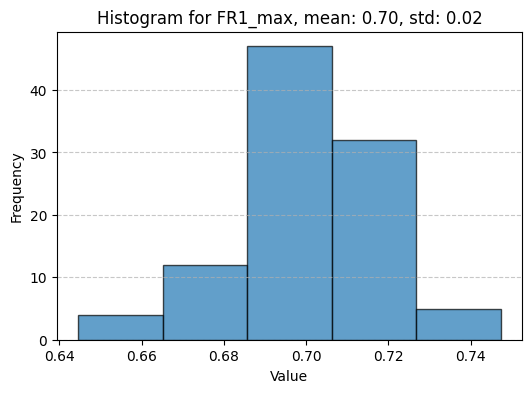

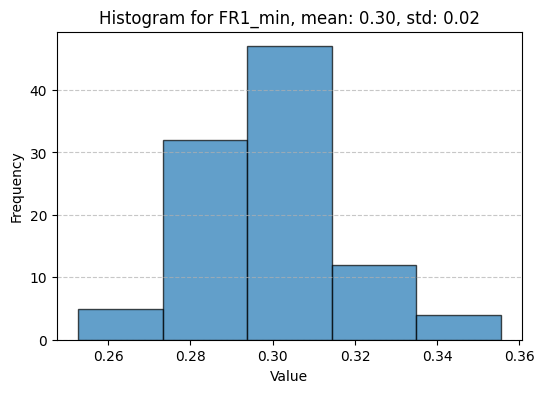

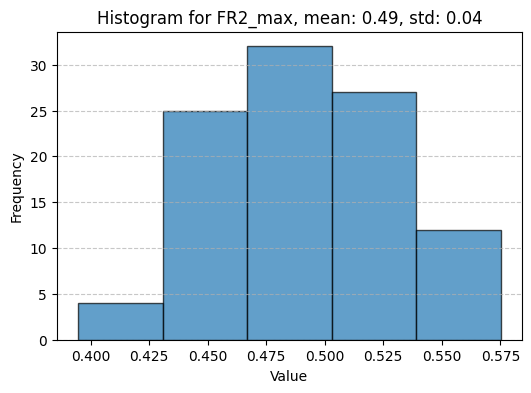

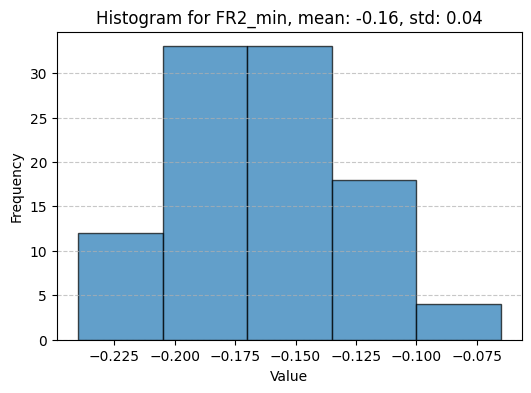

In [62]:
for k in range(len(dummyEnv.output_dict)):
    plt.figure(figsize=(6, 4))
    plt.hist(obs_collection[:, k], bins=5, edgecolor='black', alpha=0.7)
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.title(f"Histogram for {list(dummyEnv.output_dict.keys())[k]}, mean: {np.mean(obs_collection[:, k]):.2f}, std: {np.std(obs_collection[:, k]):.2f}")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()